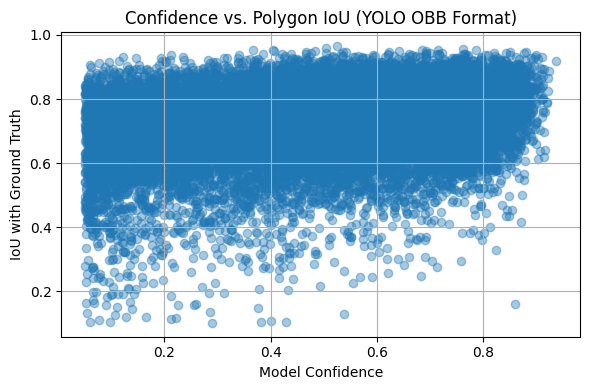

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from glob import glob

# === CONFIG ===
GT_DIR = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/final_data_neurips_2025/test/yolo_obb_labels"
PRED_DIR = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/brick_kilns_neurips_2025/notebooks/runs/obb/predict2/labels"
IMG_W, IMG_H = 128, 128  # used to un-normalize

def parse_polygon_line(line, is_pred=False):
    vals = line.strip().split()
    cls_id = int(vals[0])
    coords = list(map(float, vals[1:9]))  # x1 y1 ... x4 y4
    points = [(coords[i]*IMG_W, coords[i+1]*IMG_H) for i in range(0, 8, 2)]
    poly = Polygon(points)
    conf = float(vals[9]) if is_pred and len(vals) == 10 else 1.0
    return poly, conf

def compute_iou(poly1, poly2):
    if not poly1.is_valid or not poly2.is_valid:
        return 0
    inter = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return inter / union if union > 0 else 0

ious, confidences = [], []
# gt_files = sorted(glob(os.path.join(GT_DIR, "*.txt")))
gt_files = sorted(glob(os.path.join(GT_DIR, "*.txt")))  # only first 10 files
for gt_file in gt_files:
    fname = os.path.basename(gt_file)
    pred_file = os.path.join(PRED_DIR, fname)
    if not os.path.exists(pred_file):
        continue
    # Load GT and Pred polygons
    with open(gt_file) as f:
        gt_polys = [parse_polygon_line(line)[0] for line in f if line.strip()]

    with open(pred_file) as f:
        pred_entries = [parse_polygon_line(line, is_pred=True) for line in f if line.strip()]
        pred_polys = [e[0] for e in pred_entries]
        pred_confs = [e[1] for e in pred_entries]
    matched_gt = set()
    for pred_poly, conf in zip(pred_polys, pred_confs):
        best_iou = 0
        best_idx = -1
        for i, gt_poly in enumerate(gt_polys):
            if i in matched_gt:
                continue
            iou = compute_iou(pred_poly, gt_poly)
            if iou > best_iou:
                best_iou = iou
                best_idx = i
        if best_iou > 0.1:  # match threshold
            matched_gt.add(best_idx)
            ious.append(best_iou)
            confidences.append(conf)
# === Plot ===
plt.figure(figsize=(6, 4))
plt.scatter(confidences, ious, alpha=0.4)
plt.xlabel("Model Confidence")
plt.ylabel("IoU with Ground Truth")
plt.title("Confidence vs. Polygon IoU (YOLO OBB Format)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
# === Bin Confidence and Compute Mean IoU per Bin ===
bin_edges = np.arange(0.0, 1.01, 0.1)  # [0.0, 0.1, ..., 1.0]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_avg_ious = []

for i in range(len(bin_edges) - 1):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i+1]
    bin_ious = [iou for iou, conf in zip(ious, confidences) if bin_start <= conf < bin_end]
    if bin_ious:
        bin_avg_ious.append(np.mean(bin_ious))
    else:
        bin_avg_ious.append(0.0)


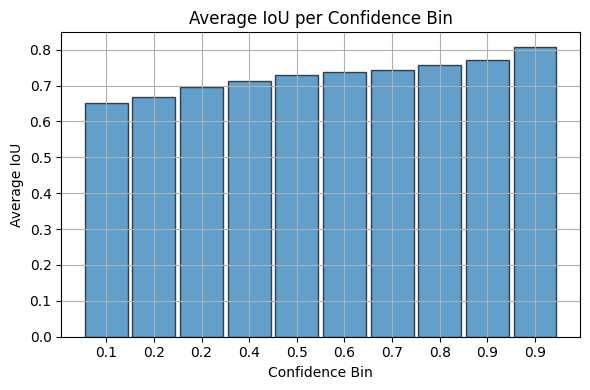

In [3]:
plt.figure(figsize=(6, 4))
plt.bar(bin_centers, bin_avg_ious, width=0.09, edgecolor='black', alpha=0.7)
plt.xlabel("Confidence Bin")
plt.ylabel("Average IoU")
plt.title("Average IoU per Confidence Bin")
plt.grid(True)
plt.xticks(bin_centers, [f"{b:.1f}" for b in bin_centers])
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

# Define confidence bins
bin_edges = np.arange(0.0, 1.01, 0.2)  # [0.0, 0.2, 0.4, ..., 1.0]
bin_labels = [f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}" for i in range(len(bin_edges) - 1)]

# Bin each confidence
binned = pd.cut(confidences, bins=bin_edges, labels=bin_labels, right=False)

# Create dataframe of results
df = pd.DataFrame({
    "ConfidenceBin": binned,
    "IoU": ious
})

# Group by bin and count
summary = df.groupby("ConfidenceBin").agg(
    Count=("IoU", "count"),
    Avg_IoU=("IoU", "mean"),
    Min_IoU=("IoU", "min"),
    Max_IoU=("IoU", "max")
).reset_index()

# import ace_tools as tools; tools.display_dataframe_to_user(name="Confidence Bin Summary", dataframe=summary)


/tmp/ipykernel_3625376/2656460382.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("ConfidenceBin").agg(


In [6]:
summary

,ConfidenceBin,Count,Avg_IoU,Min_IoU,Max_IoU
0,0.0-0.2,2317,0.661643,0.103701,0.930954
1,0.2-0.4,3375,0.705147,0.101736,0.952797
2,0.4-0.6,5349,0.734675,0.103378,0.964898
3,0.6-0.8,5639,0.750912,0.247711,0.956418
4,0.8-1.0,1440,0.773520,0.162128,0.946560


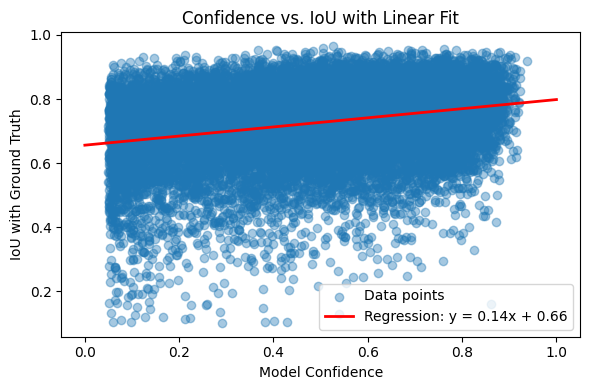

In [8]:
# === Fit linear regression line ===
conf_array = np.array(confidences)
iou_array = np.array(ious)

# Fit y = mx + b
m, b = np.polyfit(conf_array, iou_array, deg=1)
line_x = np.linspace(0, 1, 100)
line_y = m * line_x + b

# === Plot with regression line ===
plt.figure(figsize=(6, 4))
plt.scatter(confidences, ious, alpha=0.4, label='Data points')
plt.plot(line_x, line_y, color='red', linewidth=2, label=f'Regression: y = {m:.2f}x + {b:.2f}')
plt.xlabel("Model Confidence")
plt.ylabel("IoU with Ground Truth")
plt.title("Confidence vs. IoU with Linear Fit")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
from scipy.stats import pearsonr

# Compute Pearson correlation
r, p_value = pearsonr(confidences, ious)

print(f"Pearson correlation coefficient (r): {r:.4f}")
print(f"P-value: {p_value:.4e}")


Pearson correlation coefficient (r): 0.2762
P-value: 1.4470e-314


Pearson Correlation (r): 0.2762, p-value: 1.4470e-314
Linear R² score: 0.0763
Polynomial (deg=2) R² score: 0.0786


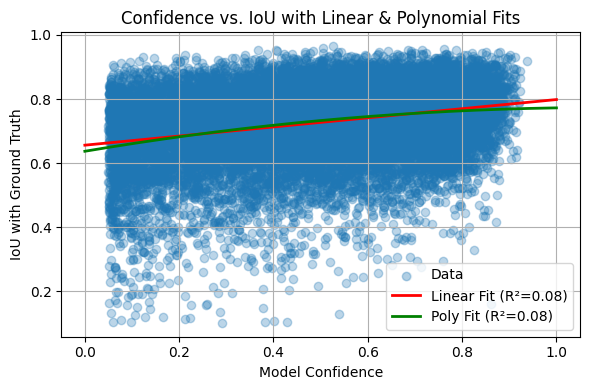

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# Convert to arrays
conf_array = np.array(confidences)
iou_array = np.array(ious)

# === Pearson correlation ===
r, p_val = pearsonr(conf_array, iou_array)
print(f"Pearson Correlation (r): {r:.4f}, p-value: {p_val:.4e}")

# === Linear regression ===
m, b = np.polyfit(conf_array, iou_array, 1)
linear_pred = m * conf_array + b
r2_linear = r2_score(iou_array, linear_pred)
print(f"Linear R² score: {r2_linear:.4f}")

# === Polynomial regression (degree 2) ===
poly_coeffs = np.polyfit(conf_array, iou_array, 2)
poly_model = np.poly1d(poly_coeffs)
poly_pred = poly_model(conf_array)
r2_poly = r2_score(iou_array, poly_pred)
print(f"Polynomial (deg=2) R² score: {r2_poly:.4f}")

# === Plot with linear & poly fit ===
x_vals = np.linspace(0, 1, 200)
y_linear = m * x_vals + b
y_poly = poly_model(x_vals)

plt.figure(figsize=(6, 4))
plt.scatter(conf_array, iou_array, alpha=0.3, label="Data")
plt.plot(x_vals, y_linear, color='red', lw=2, label=f"Linear Fit (R²={r2_linear:.2f})")
plt.plot(x_vals, y_poly, color='green', lw=2, label=f"Poly Fit (R²={r2_poly:.2f})")
plt.xlabel("Model Confidence")
plt.ylabel("IoU with Ground Truth")
plt.title("Confidence vs. IoU with Linear & Polynomial Fits")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
